In [ ]:
import sys
path = "../../.."
if path not in sys.path:
    sys.path.insert(0, path)


import matplotlib.pyplot as plt
import numpy as np
from data_retrieval import lipade_groundtruth
from data_retrieval.tools.data_loader import getDataLoader
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from data_retrieval import lipade_groundtruth
from clustering.clustering import getPredictionFromThreshold
import clustering.evaluators as evaluators
import csv

from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

optimizerFunc = optim.Adam
temperature = 0.07
learningRate = 3e-4
batch_size = 128 # metttre plus grand
workers = 2
extract = 800
epochs = 20
corpus = "lipade_groundtruth"
resultsPath = "/home/renard/highvision/representation/image/results/distance/" + corpus + "/"
csv_filename = "results_slip.csv"
extract = 100


import torch
torch.cuda.empty_cache()



cuda:0


In [2]:
# ## Dataset


# Test
xSim,_,ySim = lipade_groundtruth.getDataset(mode = 'similar', uniform=True)
_,_,y_test = lipade_groundtruth.getDataset(mode="similar")

imagesSim = []
for i in range(len(xSim)):
    try:
        imagesSim.append(Image.open(xSim[i]).convert('RGB'))
    except:
        print("Error loading image:", xSim[i])

testLoader = getDataLoader(imagesSim, None, None, False, batch_size, shuffle=False, num_workers=2)


# Train/val
# Images
x,m,_ = lipade_groundtruth.getDataset(mode="unique", uniform=True)

#x = x[:extract]
#m[0] = m[0][:extract]
#m[2] = m[2][:extract]

is_recto = np.array(m[2])
x = np.array(x)[is_recto]

# Captions
captions = m[1]
images_per_captions = {}
images = []
for file,prompt in captions.keys():
    images_per_captions[prompt] = []

for i in range(len(x)):
    f = '/'.join(x[i].split('/')[-2:])
    if (f, prompt) not in captions.keys():
        images.append(x[i])

x = x.tolist()
for im in images:
    x.remove(im)

for prompt in images_per_captions.keys():
    for i in range(len(x)):
        f = '/'.join(x[i].split('/')[-2:])
        images_per_captions[prompt].append(captions[(f, prompt)])

class CustomDataset(Dataset):
    def __init__(self, image_paths, captions):
        self.image_paths = image_paths
        self.captions = captions
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return image, image_path, self.captions[idx], idx
    
    



captions = images_per_captions["a black and white photo of "]

train_images, val_images, train_captions, val_captions = train_test_split(
    x, captions, test_size=0.1, random_state=42
)

train_loader = DataLoader(CustomDataset(train_images, train_captions), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CustomDataset(val_images, val_captions), batch_size=batch_size, shuffle=False)



In [3]:
from degradations.methods import transforms_atkinson_dithering, transforms_bayer_halftoning, transforms_floyd_steinberg_halftoning, transforms_drawing, transforms_erased_element, transforms_paint, transforms_non_rectangular_frame, transforms_patchwork, transforms_photo_montage, transforms_picture_overlay, transforms_text_overlay, transforms_dirty_rollers, transforms_add_gaussian_noise, transforms_add_salt_and_pepper_noise, transforms_bleedthrough, transforms_contrast, transforms_crumpled_paper, transforms_folded_paper, transforms_ink_bleed, transforms_book, transforms_stains, transforms_scribbles, transforms_torn_paper


class transforms_SepiaFilter(nn.Module):
    def __init__(self):
        super(transforms_SepiaFilter, self).__init__()

    def __call__(self, batch):
        sepia_filter = torch.tensor([[0.393, 0.769, 0.189],
                                     [0.349, 0.686, 0.168],
                                     [0.272, 0.534, 0.131]], device=batch.device)
        batch = torch.einsum('ijkl,mj->imkl', batch, sepia_filter)
        return batch.clamp(0, 1)





list_degrads = [
        # halftone
        transforms_floyd_steinberg_halftoning(),
        transforms_atkinson_dithering(),
        transforms_bayer_halftoning(),
        # layout
        transforms_picture_overlay(),
        transforms_text_overlay(),
        transforms_non_rectangular_frame(),
        transforms_photo_montage(),
        # human
        transforms_erased_element(),
        #transforms_drawing(),
        #transforms_paint(),
        # noise
        transforms_add_gaussian_noise(),
        transforms_add_salt_and_pepper_noise(),
        transforms_dirty_rollers(),
        # stains
        #transforms_scribbles(),
        transforms_stains(),
        transforms_ink_bleed(),
        transforms_bleedthrough(),
        # texture
        transforms_crumpled_paper(),
        transforms_folded_paper(),
        transforms_torn_paper(),
        # sepia
        transforms_SepiaFilter()]



transform = transforms.Compose([
            transforms.RandomChoice([
                transforms.RandomResizedCrop(size=224, scale=(1/2, 1), ratio=(1, 1)),
                transforms.RandomHorizontalFlip(p=1),
                transforms.RandomVerticalFlip(p=1),
                *list_degrads]),
            transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=9)], p=0.5),
        ])



# Charger CLIP complet
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") #.to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Projection SimCLR
class ProjectionMLP(nn.Module):
    def __init__(self, in_dim=512, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        return self.mlp(x)

proj = ProjectionMLP(in_dim=512) #.to(device)

# Optimizer
optimizer = optim.AdamW(
    list(clip_model.vision_model.parameters()) + list(proj.parameters()),
    lr=5e-6
)

temperature = 0.07
lambda_clip = 0.7
lambda_simclr = 1.0

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
# SimCLR Loss
def infoNCEloss(z1, z2, t=1):
    z = torch.cat([z1, z2], dim=0)

    s = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
    exp_s = torch.exp(s / t)
    indicatorMask = torch.eye(s.shape[0], dtype=torch.bool, device=z.device) # True on diagonal, False elsewhere
    exp_s = exp_s.masked_fill(indicatorMask, 0)

    numerator = F.cosine_similarity(z1, z2, dim=-1)      # for z1
    numerator = torch.cat([numerator, numerator], dim=0) # for z2
    numerator = torch.exp(numerator / t)

    denominator = exp_s.sum(dim=1)

    l = -torch.log(numerator / denominator)
    return l.mean()


# CLIP Loss
def clip_similarity_loss(image_embeds, text_embeds, t):
    image_embeds = F.normalize(image_embeds, dim=-1)
    text_embeds = F.normalize(text_embeds, dim=-1)
    logits = (image_embeds @ text_embeds.T) / t
    labels = torch.arange(len(image_embeds)) #, device=device)
    return F.cross_entropy(logits, labels)


# Training Loop
def train_joint(train_loader, transform, name, epochs=5):
    clip_model.train()
    proj.train()
    losses_simclr_all_epoch = []
    losses_clip_all_epoch = []

    for epoch in range(epochs):
        losses_simclr = []
        losses_clip = []

        for (img, img_paths, captions, idx) in tqdm(train_loader):
            images = [Image.open(p).convert("RGB") for p in img_paths]
            
            # --- SIMCLR PART ---
            
            x = img #.to(device)
            x2 = transform(img) #.to(device)

            with torch.no_grad():
                v1 = clip_model.get_image_features(pixel_values=x)
                v2 = clip_model.get_image_features(pixel_values=x2)

            z1 = proj(v1)
            z2 = proj(v2)

            loss_simclr = infoNCEloss(z1, z2, temperature)

            # --- CLIP PART ---
            
            inputs = processor(images=images, text=captions, return_tensors="pt", padding=True) #.to(device)

            outputs = clip_model(**inputs)
            img_emb = outputs.image_embeds
            txt_emb = outputs.text_embeds

            loss_clip = clip_similarity_loss(img_emb, txt_emb, temperature)

            # --- TOTAL LOSS ---
            loss_total = lambda_simclr * loss_simclr + lambda_clip * loss_clip
            
            optimizer.zero_grad()
            loss_total.backward()
            optimizer.step()

            losses_simclr.append(loss_simclr.item())
            losses_clip.append(loss_clip.item())

        print(f"[Epoch {epoch}] SimCLR: {np.mean(losses_simclr):.4f} | CLIP: {np.mean(losses_clip):.4f}")
        losses_simclr_all_epoch.append(np.mean(losses_simclr))
        losses_clip_all_epoch.append(np.mean(losses_clip))

        torch.save({
            "clip": clip_model.state_dict(),
            "proj": proj.state_dict()
        }, f"SLIP_{name}.pth")
    
    plt.plot(losses_simclr_all_epoch)
    plt.savefig(f"loss_slip_simclr_{name}.png")
    plt.close()

    plt.plot(losses_clip_all_epoch)
    plt.savefig(f"loss_slip_clip_{name}.png")
    plt.close()



In [5]:
train_joint(train_loader, transform, "test3", epochs=epochs)

100%|██████████| 37/37 [38:41<00:00, 62.75s/it]


[Epoch 0] SimCLR: 3.6609 | CLIP: 3.1271


100%|██████████| 37/37 [36:56<00:00, 59.91s/it]  


[Epoch 1] SimCLR: 3.1837 | CLIP: 2.3030


100%|██████████| 37/37 [45:55<00:00, 74.48s/it]  


[Epoch 2] SimCLR: 3.0280 | CLIP: 1.8974


100%|██████████| 37/37 [40:13<00:00, 65.23s/it]  


[Epoch 3] SimCLR: 3.6059 | CLIP: 1.6007


100%|██████████| 37/37 [36:01<00:00, 58.43s/it] 


[Epoch 4] SimCLR: 2.9162 | CLIP: 1.3772


100%|██████████| 37/37 [45:25<00:00, 73.65s/it]   


[Epoch 5] SimCLR: 3.2429 | CLIP: 1.2113


100%|██████████| 37/37 [41:29<00:00, 67.29s/it]  


[Epoch 6] SimCLR: 3.3479 | CLIP: 1.0875


100%|██████████| 37/37 [42:29<00:00, 68.90s/it]  


[Epoch 7] SimCLR: 3.2927 | CLIP: 0.9871


100%|██████████| 37/37 [44:56<00:00, 72.88s/it] 


[Epoch 8] SimCLR: 3.0424 | CLIP: 0.9069


100%|██████████| 37/37 [46:30<00:00, 75.42s/it] 


[Epoch 9] SimCLR: 3.4377 | CLIP: 0.8304


100%|██████████| 37/37 [44:07<00:00, 71.56s/it]  


[Epoch 10] SimCLR: 3.2460 | CLIP: 0.7893


100%|██████████| 37/37 [38:24<00:00, 62.29s/it]


[Epoch 11] SimCLR: 4.0058 | CLIP: 0.7384


100%|██████████| 37/37 [34:59<00:00, 56.73s/it]


[Epoch 12] SimCLR: 3.2915 | CLIP: 0.7022


100%|██████████| 37/37 [53:07<00:00, 86.16s/it]  


[Epoch 13] SimCLR: 2.8460 | CLIP: 0.6680


100%|██████████| 37/37 [42:23<00:00, 68.75s/it]  


[Epoch 14] SimCLR: 3.5518 | CLIP: 0.6428


100%|██████████| 37/37 [22:32<00:00, 36.56s/it]  


[Epoch 15] SimCLR: 3.7436 | CLIP: 0.6074


100%|██████████| 37/37 [10:22<00:00, 16.82s/it]


[Epoch 16] SimCLR: 3.4596 | CLIP: 0.5861


100%|██████████| 37/37 [06:59<00:00, 11.35s/it]


[Epoch 17] SimCLR: 3.5653 | CLIP: 0.5664


100%|██████████| 37/37 [11:54<00:00, 19.30s/it]


[Epoch 18] SimCLR: 2.8995 | CLIP: 0.5525


100%|██████████| 37/37 [08:29<00:00, 13.77s/it]


[Epoch 19] SimCLR: 3.0928 | CLIP: 0.5341


In [9]:
def test(clip_model, proj, name, testLoader, y_test):
    # Test 
    representations = []
    with torch.no_grad():
        for batch in testLoader:
            batch = clip_model.get_image_features(pixel_values=batch) #.to(device))
            batch = proj(batch)
            for repr in batch.tolist():
                representations.append(repr)
    
    print(np.array(representations).shape)
    sim = cosine_similarity(representations, representations)

    distance = 1 - (sim+1)/2
    distance -= np.diag(distance)

    np.save(resultsPath + f"slip_{name}.npy", distance)

    method = f"slip_{name}"

    thresholds_precision = 1000
    thresholds = np.linspace(0, 1, thresholds_precision)

    precisions, recalls, f1s = evaluators.p_r_f1_byThresholds(thresholds, distance, y_test)
    f1 = np.max(f1s)
    AP, bestThresholdIndex = evaluators.pr_curve(precisions, recalls, f1s, other=("Fei mAP", evaluators.fei_mAP(y_test, distance)), save="/home/renard/highvision/clustering/evaluation/" + corpus + "/" + method + ".png")

    thresholdsClass = np.linspace(0, 1, int(thresholds_precision / 10))
    precisions_per_class, recalls_per_class = evaluators.p_r_class_byThresholds(thresholdsClass, distance, y_test)
    fei = evaluators.fei_mAP(y_test, distance)
    sam = evaluators.goncalves_mAP(precisions_per_class, recalls_per_class)


    # Création ou ouverture du fichier en mode append
    with open(csv_filename, mode="a", newline="") as file:
        writer = csv.writer(file)

        # Écrire l'en-tête si le fichier est vide
        if file.tell() == 0:
            writer.writerow(["trial_name", "ap", "fei", "sam", "f1"])

        # Écriture des résultats
        writer.writerow([name, AP, fei, sam, f1])

    return AP, fei, sam, f1

In [7]:
trans_re = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])
testLoader = getDataLoader(imagesSim, None, trans_re, False, batch_size, shuffle=False, num_workers=2)


checkpoint = torch.load("/home/renard/highvision/representation/image/methods/SLIP_test3.pth", map_location="cpu")

clip_model.load_state_dict(checkpoint["clip"])
proj.load_state_dict(checkpoint["proj"])

<All keys matched successfully>

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(548, 128)


Thresholds: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


(np.float64(0.03254914993298988),
 np.float64(0.21897810218978103),
 np.float64(0.1367805812389723),
 np.float64(0.1143330571665286))

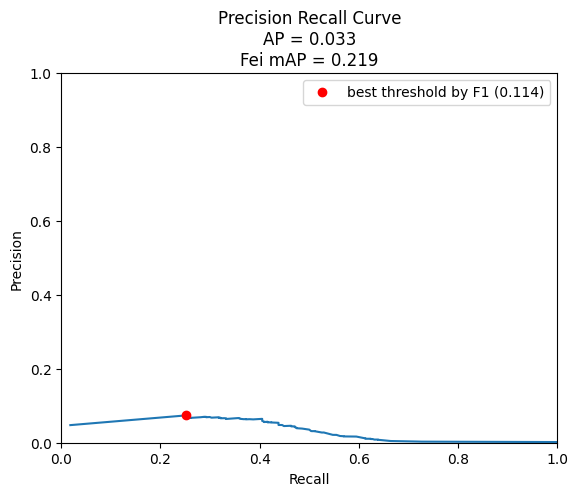

In [10]:
test(clip_model, proj, "test3", testLoader, y_test)